In [1]:
import sklearn.model_selection
import spacy
import requests
import os
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def get_fileNames(category: str):
    file_names = []
    for files in os.listdir("Data/" + category):
        if files.endswith(".csv"):
            files = files[0:len(files)-4]
            file_names.append(files)
    return file_names

In [3]:
def get_text(article: str, url="https://en.wikipedia.org/wiki/"):
    soup = BeautifulSoup(requests.get(url + article).text, "lxml")
    tags = soup.find_all("p")
    text = ""

    for i in tags:
        text += i.text

    return text

def get_similarity(article1: str, article2: str):
    nlp = spacy.load("en_core_web_lg")
    doc1 = nlp(get_text(article1))
    doc2 = nlp(get_text(article2))
    return doc1.similarity(doc2)

In [4]:
files = get_fileNames("Music")

pairs = [(a,b) for a in files for b in files]

#for article1, article2 in pairs:
    #s = get_similarity(article1, article2)
    #if s < 0.9:
    #    print(f"{get_similarity(article1, article2)} = {article1} <=> {article2}")

In [5]:
nlp = spacy.load("en_core_web_lg")
def most_common_propn(article: str, count: int, pos="PROPN"):
    doc = nlp(get_text(article))

    propn = [token.text for token in doc if token.is_alpha and not token.is_stop and token.pos_ == pos]
    return Counter(propn).most_common(count)

In [6]:
files = get_fileNames("Games")

#for file in files:
#    print(f"{file}: {most_common_propn(file, 5)}")

In [7]:
files = get_fileNames("Music")

#for file in files:
#    print(f"{file}: {most_common_propn(file, 5)}")

In [8]:
def smape(target, forecast):
    if type(target) == pd.core.frame.DataFrame:
        target = target.values

    denominator = np.abs(target) + np.abs(forecast)
    flag = denominator == 0.

    smape = 2 * np.mean(
        (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
    )
    return smape

# Moving Average

In [9]:
def moving_average(path, days_avg, days_to_predict):
    df = pd.read_csv(path)

    df.index = df["timestamp"]
    df.drop(["project", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index)

    df = df.tail(days_avg + days_to_predict)
    df_tmp = df.head(days_avg)

    prediction = []

    for i in df_tmp["views"]:
        prediction.append(i)

    for j in range(days_to_predict):
        prediction.append(sum([prediction[j + i] for i in range(days_avg)]) / days_avg)

    df["predicted"] = prediction
    return df.tail(days_to_predict)

days_to_predict = 14
days_avg = 14
def asdasd():
    for file in get_fileNames("Games"):
        df_views = pd.read_csv(f"Data/Games/{file}.csv")
        df_views.index = df_views["timestamp"]
        df_views.drop(["project", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
        df_views.index = pd.to_datetime(df_views.index)
        df_views["views"].tail(days_to_predict + days_avg).plot()

        df = moving_average(f"Data/Games/{file}.csv", days_avg, days_to_predict)
        print(smape(df["views"], df["predicted"]))
        df["predicted"].plot()

        plt.title(file)
        plt.legend()
        plt.xlabel("Tage")
        plt.ylabel("Pageviews")
        plt.show()



In [10]:
#for file in files:
#    df = moving_average(f"Data/Games/{file}.csv").tail(n)
#    loss = smape(df["views"], df["predicted"])
#    print(f"Article: {file}, loss = {loss}")
def split_train_test(data, perc):
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

# XGBoost


In [1]:
import xgboost as xgb
import itertools


def make_data(category, article):
    df = pd.read_csv(f"Data/{category}/{article}.csv")

    df.index = df["timestamp"]
    df.drop(["project", "article", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index)

    df["views"] = np.log(df["views"])

    dfN = df[["views"]].copy()
    df["target"] = df.views.shift(-1)
    df.dropna(inplace=True)

    #df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]
    dfNeu = df.tail(14)
    df = df.head(len(df) - 14)

    return df, dfNeu
x, y = make_data("Games", "Overwatch")
x

NameError: name 'pd' is not defined

In [12]:


#fig, ax = plt.subplots(figsize=(15,5))
#train_data["views"].plot(ax=ax, label="Train")
#test_data["views"].plot(ax=ax, label="Test")
#plt.legend()
#plt.show()

# Features

In [110]:
def create_features(df):
    if isinstance(df, tuple):
        df = df[0]
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    df["max"] = max(df["views"])
    df["min"] = min(df["views"])
    df["avg"] = sum(df["views"]) / len(df["views"])
    return df

def create_features2(df, dfNeu):
    if isinstance(df, tuple):
        df = df[0]

    df = df.copy()
    dfNeu["dayofweek"] = dfNeu.index.dayofweek
    dfNeu["month"] = dfNeu.index.month
    dfNeu["quarter"] = dfNeu.index.quarter
    dfNeu["dayofyear"] = dfNeu.index.dayofyear
    dfNeu["year"] = dfNeu.index.year
    dfNeu["max"] = max(df["views"])
    dfNeu["min"] = min(df["views"])
    dfNeu["avg"] = sum(df["views"]) / len(df["views"])
    return dfNeu

In [14]:
import seaborn as sns

#fig, ax = plt.subplots(figsize=(15,5))
#sns.boxplot(data=df, x="month", y="views")

In [78]:
FEATURES = ["dayofweek", "month", "quarter", "dayofyear", "year"]
TARGET = "views"
model = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.0005, eval_metric=smape)

In [79]:
def train_xgboost(category: str):
    files = get_fileNames(category)
    for file in files:
        df, _ = make_data(category, file)
        train_data, test_data = train_data, test_data = sklearn.model_selection.train_test_split(df, test_size=0.3, random_state=69)

        train_data = create_features(train_data)
        test_data = create_features(test_data)

        X_train = train_data[FEATURES]
        y_train = train_data[TARGET]

        X_test = test_data[FEATURES]
        y_test = test_data[TARGET]

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)

In [108]:
def test_xgboost(category):
    files = get_fileNames(category)
    losses = []
    for file in files:
        if file == "The World Ends With You":
            continue
        df, dfNeu = make_data(category, file)
        test_data = create_features2(df, dfNeu)

        X_test = test_data[FEATURES]
        test_data["prediction"] = model.predict(X_test)

        test_data = test_data.head(14)

        test_data["views"].plot()
        test_data["prediction"].plot()
        loss = smape(test_data["views"], test_data["prediction"])
        losses.append(loss)
        print(f"Loss: {loss}, Game: {file}")
        plt.legend()
        plt.grid()
        plt.show()
    return losses

In [84]:
train_xgboost("Music")

[0]	validation_0-rmse:815.99120	validation_0-smape:1.99451	validation_1-rmse:666.25329	validation_1-smape:1.99448


KeyboardInterrupt: 

In [2]:
#l2 = test_xgboost("Music")

In [124]:
import sklearn

def alles(category):
    losses = []
    for file in get_fileNames(category):
        model = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.005, eval_metric=smape)

        df, dfNeu = make_data(category, file)

        if len(df) == 0:
            continue

        train_data, test_data = sklearn.model_selection.train_test_split(df, test_size=0.3, random_state=69)

        #train_data, test_data = split_train_test(df, 0.2)

        train_data = create_features(train_data)
        test_data = create_features(test_data)
        dfNeu = create_features(dfNeu)

        X_neu = dfNeu[FEATURES]

        X_train = train_data[FEATURES]
        y_train = train_data[TARGET]

        X_test = test_data[FEATURES]
        y_test = test_data[TARGET]

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)

        dfNeu["prediction"] = model.predict(X_neu)

        '''
        dfNeu["views"].plot()
        dfNeu["prediction"].plot()
        plt.grid()
        plt.legend()
        plt.show()
        '''

        loss = smape(dfNeu["views"], dfNeu["prediction"])
        losses.append(loss)
        print(f"Loss: {loss}, {category}: {file}")
    return losses

music_loss = alles("Music")
games_loss = alles("Games")
#movies_loss = alles("Movies")
#liter_loss = alles("Literary")

[0]	validation_0-rmse:5.88258	validation_0-smape:1.69419	validation_1-rmse:5.87146	validation_1-smape:1.69382
[1000]	validation_0-rmse:0.19827	validation_0-smape:0.01837	validation_1-rmse:0.23472	validation_1-smape:0.02053
[1029]	validation_0-rmse:0.19653	validation_0-smape:0.01830	validation_1-rmse:0.23475	validation_1-smape:0.02056
Loss: 0.02014614862697361, Music: (Everything I Do) I Do It for You
[0]	validation_0-rmse:6.33548	validation_0-smape:1.70520	validation_1-rmse:6.31435	validation_1-smape:1.70280
[1000]	validation_0-rmse:0.12256	validation_0-smape:0.01439	validation_1-rmse:0.19287	validation_1-smape:0.02504
[1732]	validation_0-rmse:0.07845	validation_0-smape:0.01054	validation_1-rmse:0.18015	validation_1-smape:0.02412
Loss: 0.01731011234571128, Music: 7 Rings
[0]	validation_0-rmse:6.23022	validation_0-smape:1.70827	validation_1-rmse:6.21740	validation_1-smape:1.70771
[1000]	validation_0-rmse:0.14824	validation_0-smape:0.01438	validation_1-rmse:0.18035	validation_1-smape:0.0

Musik: 0.061017309845805584
Games: 0.021776692748945056


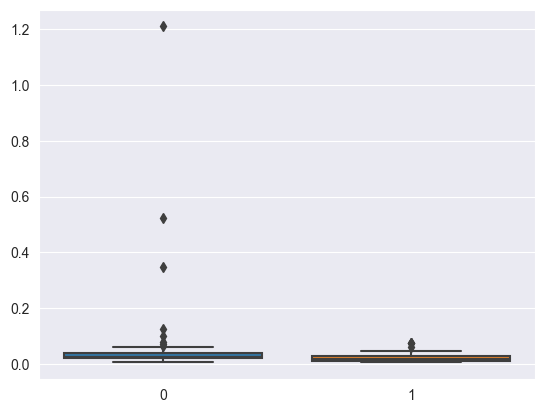

In [128]:
sns.boxplot([music_loss, games_loss])
def avgg(x):
    return sum(x) / len(x)
print(f"Musik: {avgg(music_loss)}")
print(f"Games: {avgg(games_loss)}")

<AxesSubplot: >

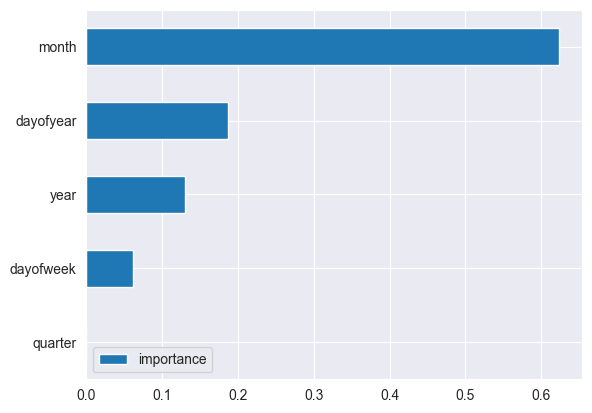

In [126]:
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=["importance"])
fi.sort_values("importance").plot(kind="barh")

# Mehr Daten

In [106]:
most_common_propn("Minecraft", 5)

FeatureNotFound: Couldn't find a tree builder with the features you requested: lxml. Do you need to install a parser library?